# Segmentation of Cell Cycles Images

SCC0251 - Image Processing

**G4** - Name: Breno Lívio Silva de Almeida, NUSP: 10276675

*This Jupyter Notebook consists of properly demonstrating the project functionalities and pipeline. It will be applied the methods for specific images but in the end it will be calculated the Jaccard Index for all available images, showing boxplot and other graphs for a better comparison.*

---

## Image pre-processing

In this step, we will do the pre-processing of the image, converting it to grayscale, applying equalization and gaussian filter. We will load the image `I4.jpg`.

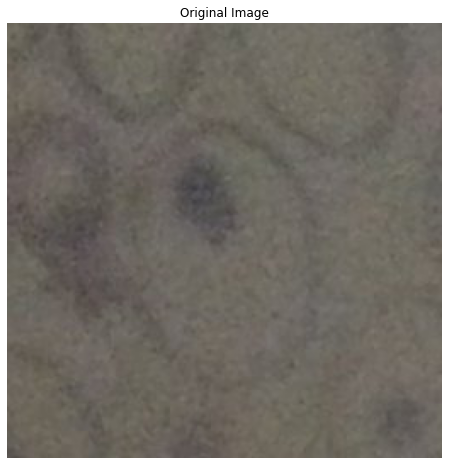

In [1]:
import ImagePreprocessing, ImageSegmentation
import matplotlib.pyplot as plt
import numpy as np
import imageio

src = "Data/Original/I4.jpg"

cellOriginal = imageio.imread(src, pilmode="RGB")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Original Image")
plt.imshow(cellOriginal);

We convert to grayscale using luminance method.

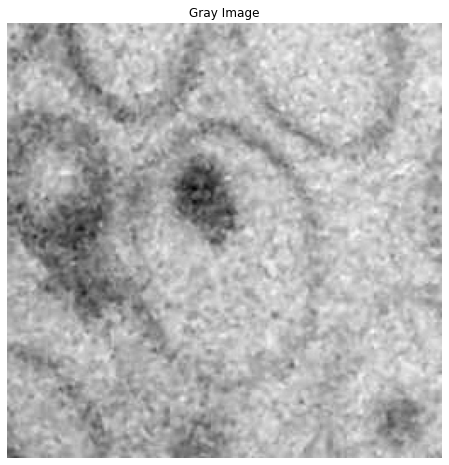

In [2]:
cellGray = ImagePreprocessing.convertLuminance(cellOriginal)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Gray Image")
plt.imshow(cellGray, cmap = "gray");

We will apply histogram equalization for the image. The idea is to better distribute the image intensities. For example, we have before applying equalization the following distribution.

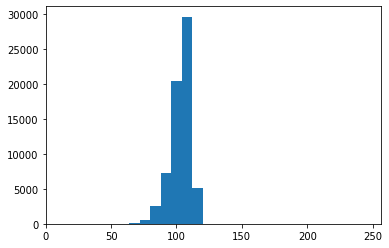

In [3]:
fig, ax = plt.subplots(1, 1)
ax.hist(cellGray.ravel(), bins = 32, range=[0, 256])
ax.set_xlim(0, 256);

Applying histogram equalization we have the following image.

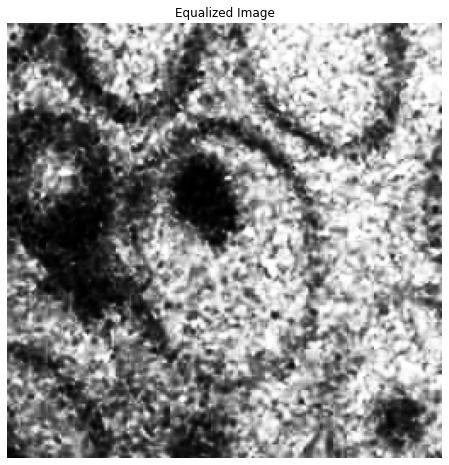

In [4]:
cellEq = ImagePreprocessing.histogramEqualization(cellGray)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Equalized Image")
plt.imshow(cellEq, cmap = "gray");

Having the following intensity distribution. A much better distributed intensity per se.

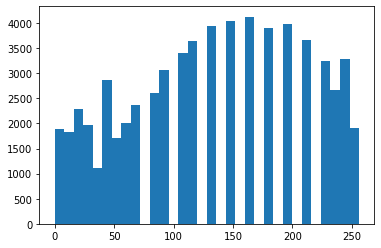

In [5]:
fig, ax = plt.subplots(1, 1)
ax.hist(cellEq.ravel(), bins = 32, range=[0, 256]);

Now we apply a Gaussian Filter. This filter will help with segmentation processing, consering how the filter can smooth the image, reducing the noise around the nuclei.

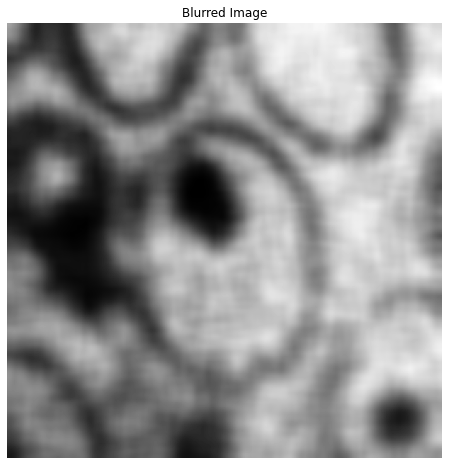

In [6]:
cellGaussian = ImagePreprocessing.gaussianFilter(cellEq, k = 15, sigma = 10)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Blurred Image")
plt.imshow(cellGaussian, cmap = "gray");

## Image Segmentation

After pre-processing the image we can work with Region-Based and Clustering Segmentation methods.

### Region-Based Segmentation

In the Region-Based route, we will work with a threshold value for dealing with intensities in the image.

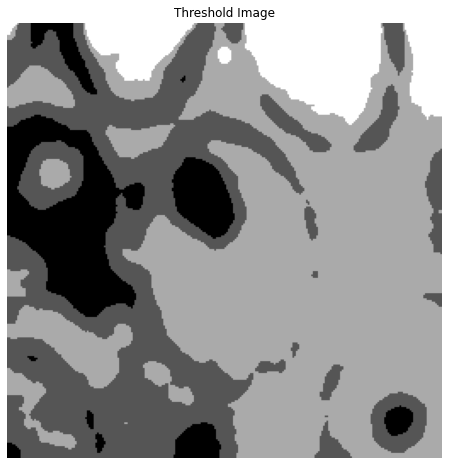

In [7]:
cellThresh = ImageSegmentation.thresholdRegion(np.copy(cellGaussian))

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Threshold Image")
plt.imshow(cellThresh, cmap = "gray");

Our Regions Of Interest (ROI) are only the darkest regions, which probably contains our nuclei, so we will isolate the ROI in a binary image.

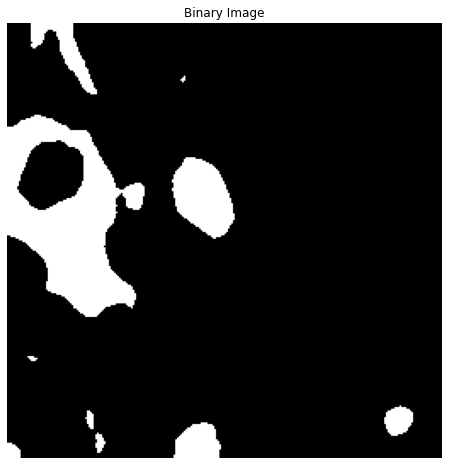

In [8]:
mask = np.ones(cellThresh.shape)
mask[np.where(cellThresh == 0)] = 0
mask = ~(mask.astype(np.uint8))

mask = ImagePreprocessing.scalingImage(mask, 0, 1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Binary Image")
plt.imshow(mask, cmap = "gray");

Using the Connected-component Labeling algorithm we can label isolated components in the image.

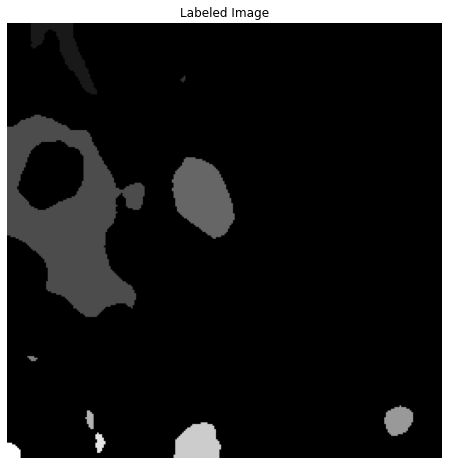

In [9]:
import ConnectedComponent

maskLabels = ConnectedComponent.connectedComponents(mask)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Labeled Image")
plt.imshow(maskLabels, cmap = "gray");

But how can we distinguish the nuclei blob from the others? For this we can say the nuclei are probably the nearest blob to the center of the image. And the blob must have a minimum and maximum number of pixels to deal with noise. This assumption is repeated throughout all the images.

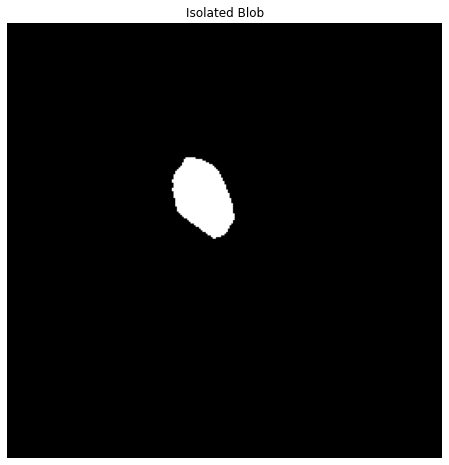

In [10]:
labels = np.unique(maskLabels)

# Calculate centers of mass for the blobs
centers = ConnectedComponent.centerOfMass(maskLabels, labels)

# Find nearest blob from the center, which is our nuclei
nearestBlob = ConnectedComponent.nearDistance(maskLabels, centers)

# Isolate blob
segmented1 = np.zeros(mask.shape)
segmented1[maskLabels == nearestBlob] = 1

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Isolated Blob")
plt.imshow(segmented1, cmap = "gray");

### Segmentation by Clustering

For Segmentation by Clustering we will use the KMeans algorithm. The number of clusters that better suited the problem is around `13`. Note that the algorithm is imported by a scikit-learn library, considering the optimization already made. A KMeans made by scratch would be really time expensive considering the number of images.

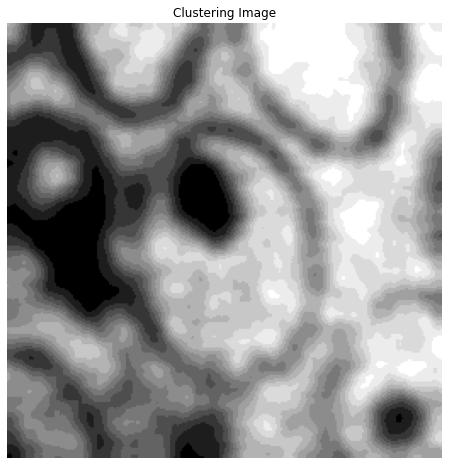

In [11]:
from sklearn.cluster import KMeans

gaussFlatten = cellGaussian.reshape(-1, 1)

# Applying clustering segmentation with KMeans
clusters = KMeans(n_clusters = 13, random_state = 0).fit(gaussFlatten)
clusterImg = clusters.cluster_centers_[clusters.labels_]
clusterImg = clusterImg.reshape(cellGaussian.shape)

clusterImg = ImagePreprocessing.scalingImage(clusterImg, 0, 1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Clustering Image")
plt.imshow(clusterImg, cmap = "gray");

As from before, our ROI are the darkest regions.

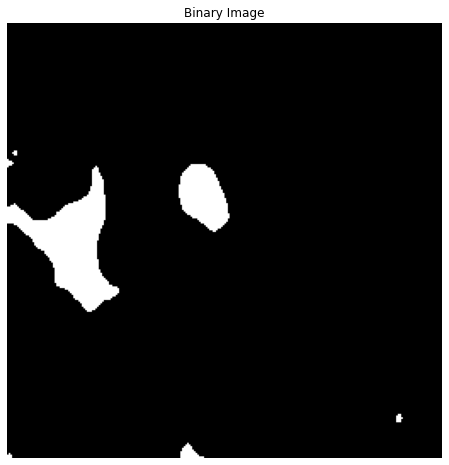

In [12]:
mask = np.ones(clusterImg.shape)
mask[np.where(clusterImg == 0)] = 0
mask = ~(mask.astype(np.uint8))

mask = ImagePreprocessing.scalingImage(mask, 0, 1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Binary Image")
plt.imshow(mask, cmap = "gray");

We use Connected-component labeling.

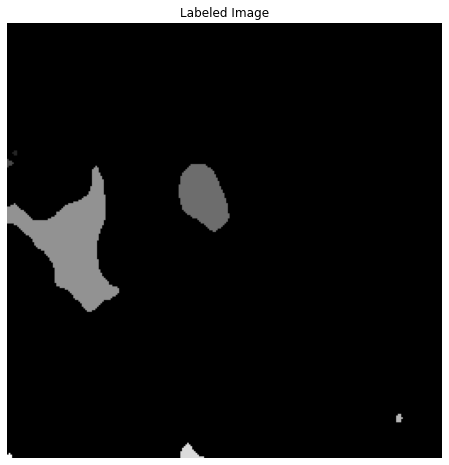

In [13]:
maskLabels = ConnectedComponent.connectedComponents(mask)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Labeled Image")
plt.imshow(maskLabels, cmap = "gray");

Finally we isolate the nearest blob to the center of the image, which is probably our nuclei.

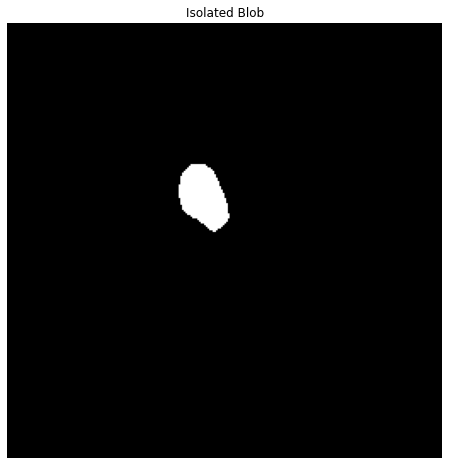

In [14]:
labels = np.unique(maskLabels)

centers = ConnectedComponent.centerOfMass(maskLabels, labels)

nearestBlob = ConnectedComponent.nearDistance(maskLabels, centers)

segmented2 = np.zeros(mask.shape)
segmented2[maskLabels == nearestBlob] = 1

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Isolated Blob")
plt.imshow(segmented2, cmap = "gray");

## Evaluating Segmentation Methods

To proper evaluate the segmentations methods, it was made by hand segmentation masks for the nuclei with the application labelme. The true mask for the image we are working would be the following.

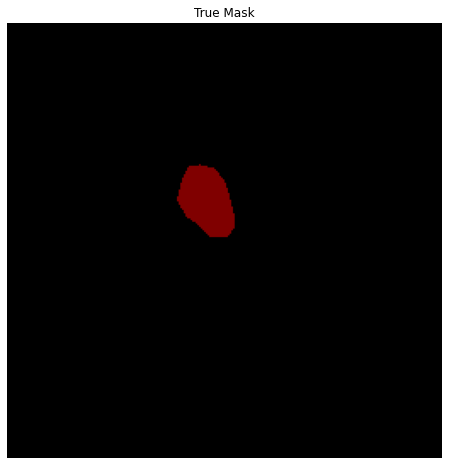

In [15]:
src = "Data/TrueMask/I4/label.png"

trueMask = imageio.imread(src, pilmode="RGB")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("True Mask")
plt.imshow(trueMask);

Now we can compare how accurate the segmentation methods are using the Jaccard Index.

In [16]:
import CalculateError

# Convert to grayscale
trueMaskGray = ImagePreprocessing.convertLuminance(trueMask)

print("IoU score for Region-Based: {:.4f}".format(CalculateError.jaccardIndex(trueMaskGray, segmented1)))
print("IoU score for Clustering: {:.4f}".format(CalculateError.jaccardIndex(trueMaskGray, segmented2)))

IoU score for Region-Based: 0.8091
IoU score for Clustering: 0.7638


Now let's calculate the Jaccard Index for all segmentations already generated, putting the scores in a Pandas DataFrame.

In [17]:
import os
import cv2
import pandas as pd

inputRefDir = "Data/TrueMask/"
inputDegImgThreshold = "Data/Threshold/"
inputDegImgKmeans = "Data/Kmeans/"

thresholdScores = {}
kMeansScores = {}

# List all the folder in the directory
for _, folder in enumerate(os.listdir(inputRefDir)):
    f = imageio.imread(inputRefDir + folder + "/label.png")

    g = imageio.imread(inputDegImgThreshold + folder + ".jpg")

    # Convert to grayscale
    f = ImagePreprocessing.convertLuminance(f)
    g = ImagePreprocessing.convertLuminance(g)

    # Resize because of size change in the segmentation step
    g = cv2.resize(g, dsize = (256, 256), interpolation = cv2.INTER_CUBIC)

    # Put in the dictionary
    thresholdScores[folder] = CalculateError.jaccardIndex(f, g)

for _, folder in enumerate(os.listdir(inputRefDir)):
    f = imageio.imread(inputRefDir + folder + "/label.png")

    g = imageio.imread(inputDegImgKmeans + folder + ".jpg")

    f = ImagePreprocessing.convertLuminance(f)
    g = ImagePreprocessing.convertLuminance(g)

    g = cv2.resize(g, dsize = (256, 256), interpolation = cv2.INTER_CUBIC)

    kMeansScores[folder] = CalculateError.jaccardIndex(f, g)


s1 = pd.Series(thresholdScores, name='Region-Based')
s2 = pd.Series(kMeansScores, name='Clustering')

dfScores = pd.concat([s1, s2], axis=1)

dfScores

,Region-Based,Clustering
I26,0.558548,0.741433
I7,0.668074,0.440362
I5,0.009040,0.500940
I53,0.771919,0.583220
I38,0.491434,0.000000
...,...,...
M28,0.818444,0.600906
I25,0.709735,0.000000
I45,0.821734,0.844567
I2,0.846561,0.746827


We can generate descriptive statistics about the scores directly from the Pandas library (in the original source code, the statistics are made by hand).

In [18]:
dfScores.describe()

,Region-Based,Clustering
count,90.000000,90.000000
mean,0.627365,0.628339
std,0.235776,0.261419
min,0.000000,0.000000
25%,0.564729,0.631541
50%,0.698055,0.726692
75%,0.804889,0.782045
max,0.884067,0.877956


The IoU average score is practically the same for both methods. For a better comparison we can use hypothesis tests as t-test considering:

$$H_{0}: \mu_{\text{1}} = \mu_{\text{2}}$$
$$H_{1}: \mu_{\text{1}} < \mu_{\text{2}}$$

Being $\mu_{1}$, mean score of Region-Based, and $\mu_{2}$, mean score of Clustering.

In [19]:
from scipy import stats

pvalue = stats.ttest_ind(dfScores.iloc[:, 0], dfScores.iloc[:, 1], equal_var = False, alternative = 'less')[1]

pvalue

0.4895484022485623

The p-value is too high, so we reject to fail the null hypothesis of equal means. This means there's no statistical significance in relation to the IoU average scores.

But this doesn't tell us the whole story. Let's work with boxplots.

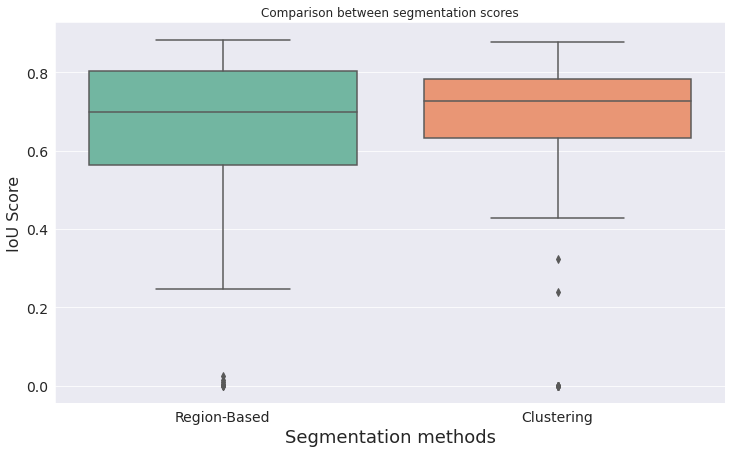

In [20]:
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.set_style("darkgrid")
sns.boxplot(data = dfScores, palette = "Set2")
plt.title("Comparison between segmentation scores")
plt.xlabel('Segmentation methods', fontsize=18)
plt.ylabel('IoU Score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(True)

With boxplots we can better see a difference between the two segmentation methods. The average score is identical, but the score distribution has its differences.

Comparing the 1st Quartile for both, we can see a higher value for clustering, showing how this method had less inaccurate cases. In general, the clustering method is more consistent.

We can also see some outliers, probably cases with a high misclassification. We can count how many outliers we have for each method. The number of outliers for both is similar.

In [21]:
Q1 = dfScores.quantile(0.25)
Q3 = dfScores.quantile(0.75)
IQR = Q3 - Q1

((dfScores < (Q1 - 1.5 * IQR)) | (dfScores > (Q3 + 1.5 * IQR))).sum()

Region-Based     8
Clustering      13
dtype: int64

We can explore further separating for the scores of interphase and mitosis cycles.

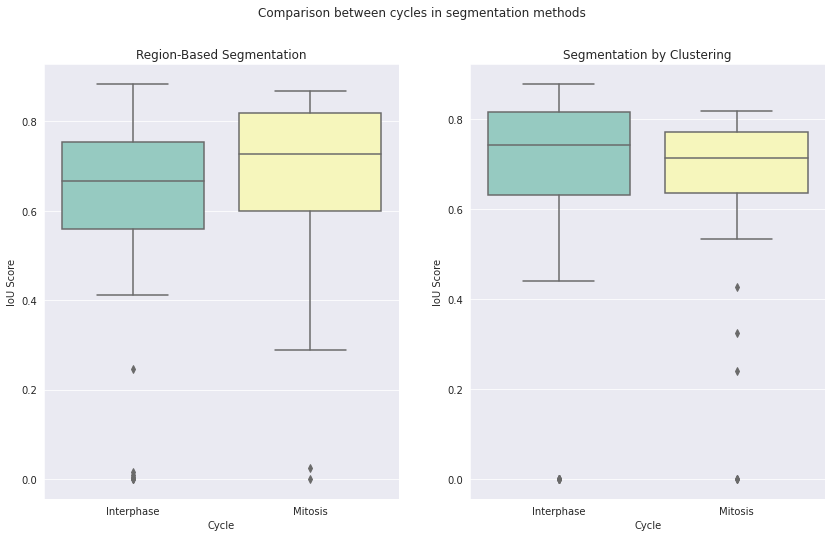

In [22]:
df = dfScores.copy()

df['Cycle'] = df.index.str.contains("^I")

df['Cycle'] = df['Cycle'].apply(lambda x: 'Interphase' if x else 'Mitosis')

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

fig.suptitle('Comparison between cycles in segmentation methods')

sns.boxplot(ax = axes[0], data = df, x = 'Cycle', y = 'Region-Based', palette = "Set3");
axes[0].set(ylabel='IoU Score', title = 'Region-Based Segmentation');
sns.boxplot(ax = axes[1], data = df, x = 'Cycle', y = 'Clustering', palette = "Set3");
axes[1].set(ylabel='IoU Score', title = 'Segmentation by Clustering');

We can see a difference in how each segmentation method handled the cycles. Note that it was expected segmentation by clustering would perform slightly worst than region-based, considering how the clustering method was not getting nuclei borders properly. So, the segmentation could get only a nucleus in a mitosis cycle if the nuclei are not too close.

Let's explore an outlier for clustering and see this happening.

In [23]:
Q1 = df['Clustering'].quantile(0.25)
Q3 = df['Clustering'].quantile(0.75)
IQR = Q3 - Q1

df[(df['Clustering'] < (Q1 - 1.5 * IQR)) | (df['Clustering'] > (Q3 + 1.5 * IQR))]

,Region-Based,Clustering,Cycle
I38,0.491434,0.000000,Interphase
M11,0.822393,0.324451,Mitosis
I56,0.539897,0.000000,Interphase
M2,0.024377,0.000000,Mitosis
I29,0.014907,0.000000,Interphase
I46,0.646503,0.000000,Interphase
M14,0.289038,0.000000,Mitosis
M13,0.717434,0.238999,Mitosis
I13,0.698079,0.000000,Interphase
I23,0.726119,0.000000,Interphase


We will work with `M13`, seeing how it's better in Region-Based and worst in clustering method. The true mask would be the following.

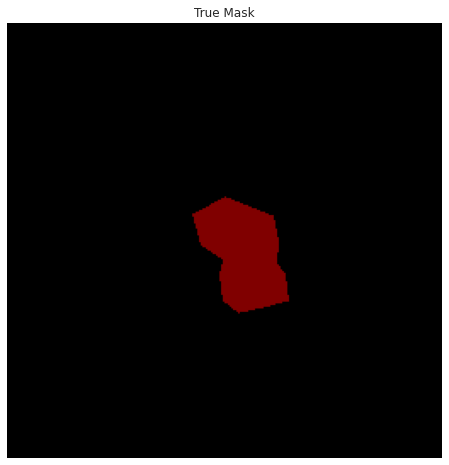

In [24]:
src = "Data/TrueMask/M13/label.png"

trueMask = imageio.imread(src, pilmode="RGB")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("True Mask")
plt.imshow(trueMask);

Now for Region-Based.

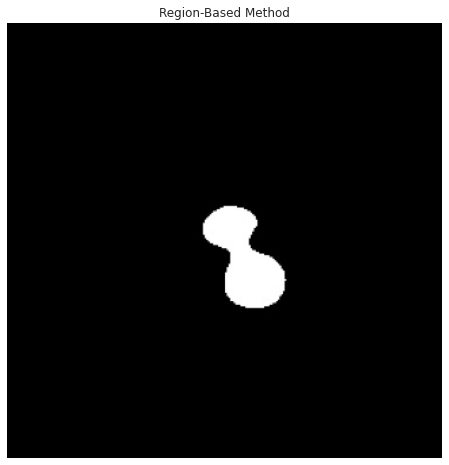

In [25]:
src = "Data/Threshold/M13.jpg"

regImg = imageio.imread(src, pilmode="RGB")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Region-Based Method")
plt.imshow(regImg);

And for Clustering.

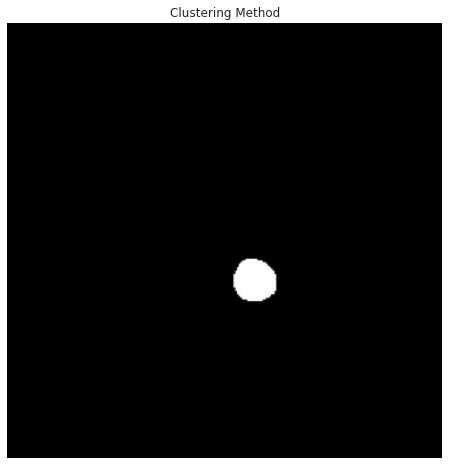

In [26]:
src = "Data/Kmeans/M13.jpg"

clustImg = imageio.imread(src, pilmode="RGB")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Clustering Method")
plt.imshow(clustImg);

Of course, this is the original image.

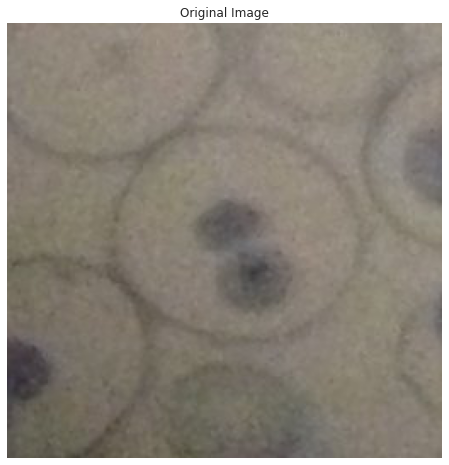

In [27]:
src = "Data/Original/M13.jpg"

originImg = imageio.imread(src, pilmode="RGB")

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Original Image")
plt.imshow(originImg);

It did actually get only one nucleus. This problem could be solved using mathematical morphology with dilation that could group one nucleus to another.

And it's important to see the true mask was somewhat exaggerated, and one of the obvious justifications is the image's lighting. So, this must be taken in consideration as "human bias". 